In [49]:
%matplotlib inline
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import pickle
import os
import sys
from DPMoSt import DPMoSt # type: ignore
from utility import plot_solution, plot_data, data_creation # type: ignore
import warnings
import scipy # type: ignore
warnings.filterwarnings("ignore")

from utility import sigmoid_eval # type: ignore
import torch
from decimal import Decimal

In [50]:
plt.style.use('seaborn-v0_8-darkgrid')

In [51]:
dpi=100
idx=0

dict_monotonicity = {'Hippocampus' : -1, #decreasing
                    'Ventricles': 1, #increasing
                    'Entorhinal': -1, #decreasing
                    'WholeBrain': -1, #decreasing
                    'ADAS11': 1, #increasing
                    'FAQ': 1, #increasing
                    'AV45': 1, #increasing
                    'FDG': -1, #decreasing
                    'MMSE': -1, #decreasing
                    'CDRSB': 1 #increasing
                    }

In [52]:
dict_data = data_creation(n_subjects=20, n_time_points=3, n_features=len(dict_monotonicity), noise_std=0.5, 
                  max_dist=1, min_dist=0, time_shifted=True, save=False)
true_groups = dict_data['sub_pop']
data = dict_data['data']
data.columns = ['subj_id', 'time'] + list(dict_monotonicity.keys())
data.head()

,subj_id,time,Hippocampus,Ventricles,Entorhinal,WholeBrain,ADAS11,FAQ,AV45,FDG,MMSE,CDRSB
0,0,0.000000,-0.783540,0.060449,0.310175,-0.323898,-0.874576,-1.004673,0.495651,0.048754,0.380426,0.678139
1,0,8.048048,0.435737,0.531543,2.246388,1.341039,0.032889,-0.386207,1.073897,0.727740,0.402329,-0.514383
2,0,13.293294,1.024106,1.854851,2.929951,2.524659,2.721818,1.400464,2.650496,0.558822,2.363329,1.207200
3,1,0.000000,-0.750189,-0.109738,0.312622,0.814644,-0.697279,-0.066565,0.826206,0.272828,0.127003,-0.117690
4,1,1.841842,0.643649,0.240765,1.216982,1.064426,1.619662,0.255575,1.185948,0.562794,0.669479,-0.734132


In [53]:
print(f'Database shape: {data.shape[0]}x{data.shape[1]}')
print(f"Subjects: {len(data['subj_id'].unique())}")
print(f"Average number of time points for subject: {data.groupby('subj_id')['time'].nunique().values.mean()}")

Database shape: 60x12
Subjects: 20
Average number of time points for subject: 3.0


In [54]:
device = 'cpu'

dpmost=DPMoSt(data=data, 
                device=device, 
                do_normalisation=True,
                dict_monotonicity=dict_monotonicity,
                benchmarks=False,
                lambda_reg_noise=0.05*data['subj_id'].unique().shape[0], 
                lambda_reg_xi=0.05*data['subj_id'].unique().shape[0],
                n_prints=1, 
                verbose=True)

Initialisation:
    Num samples: 60
    Num subjects: 20
    Num features: 10
    Evaluation time-shift: True
    Lambda regression xi: 1.0
    Lambda regression noise: 1.0
    Lambda regression theta: 0.001



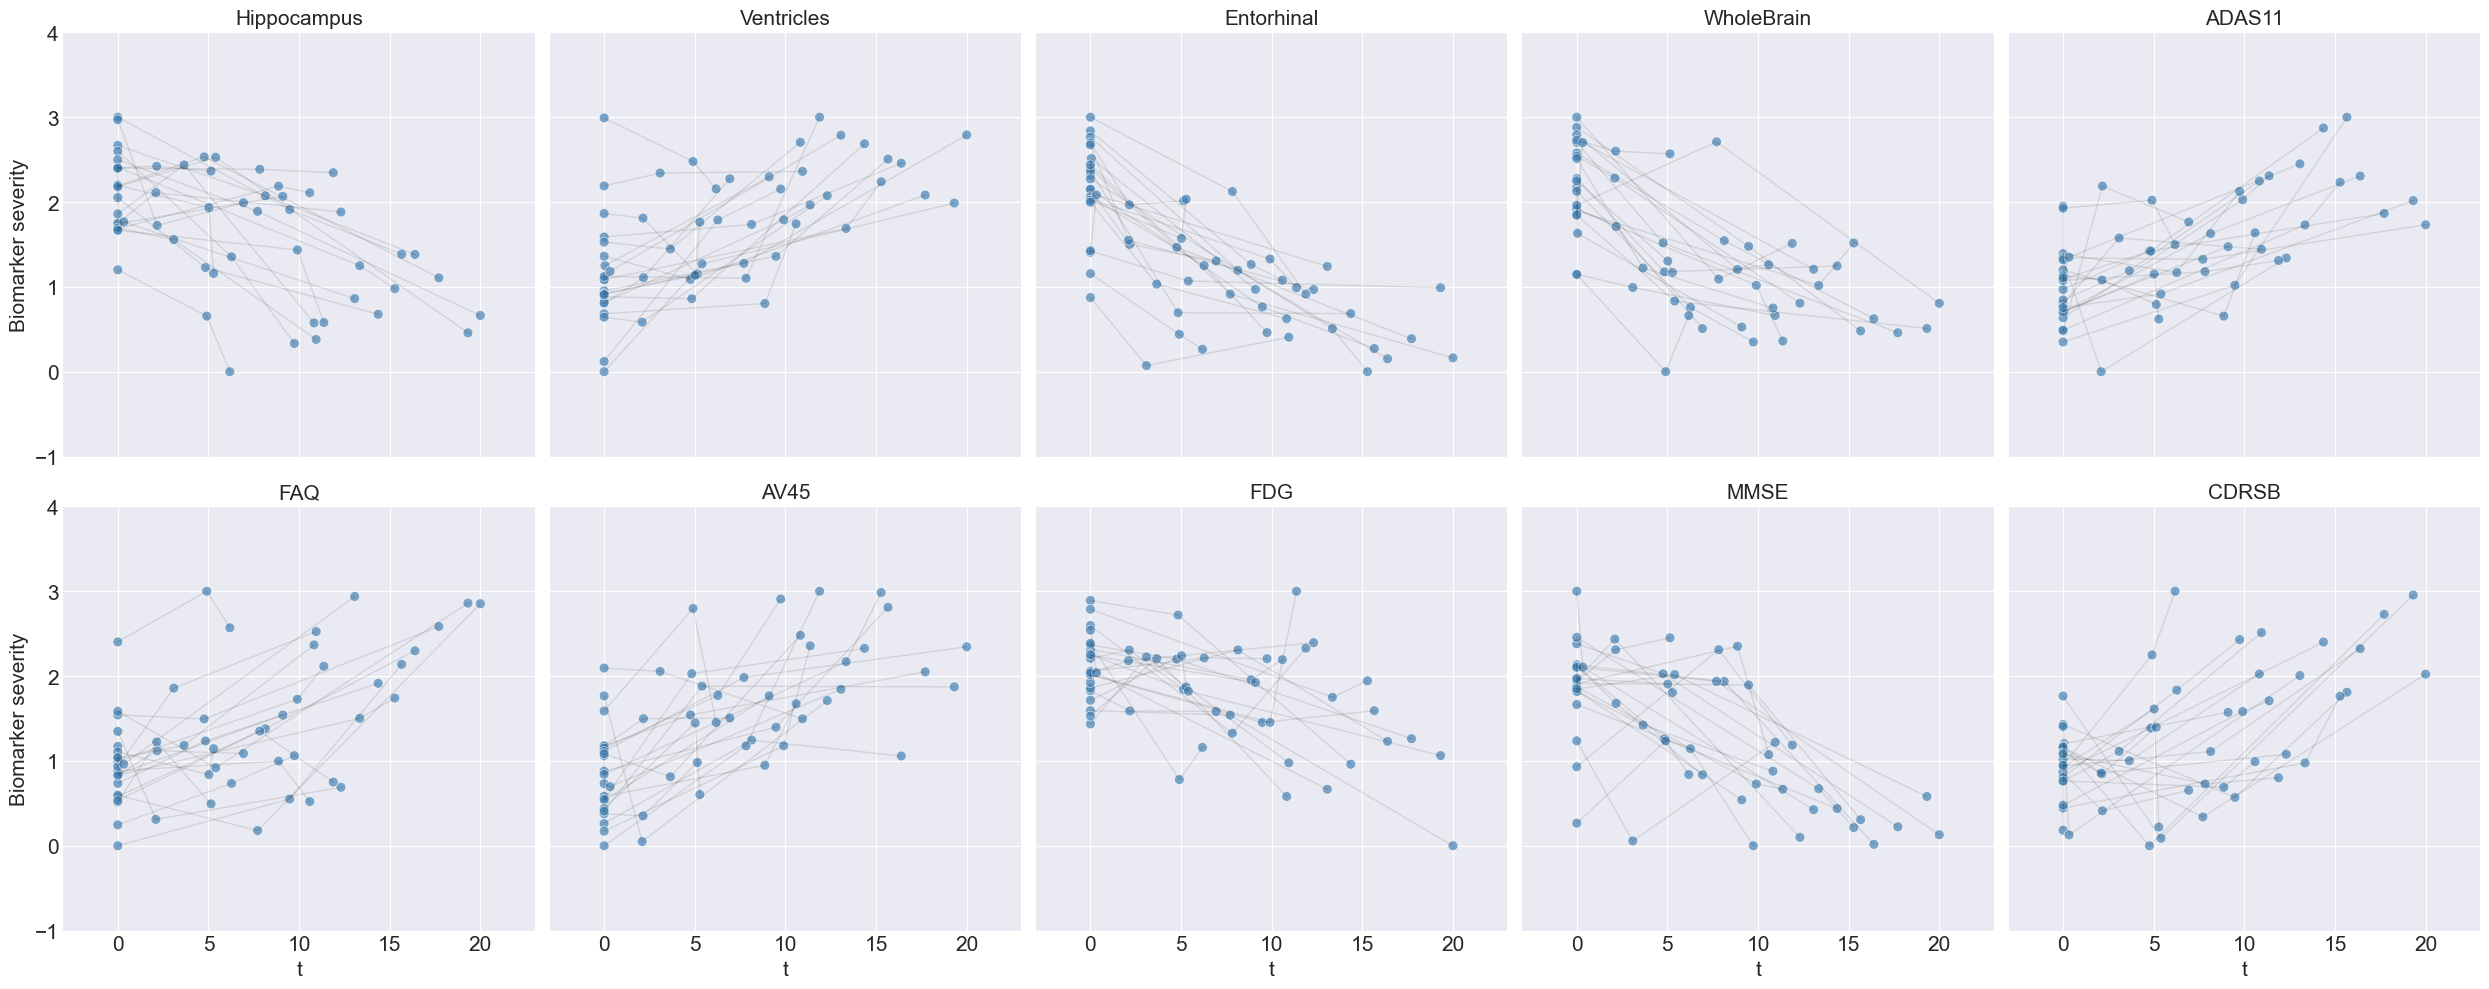

In [55]:
plot_data(dpmost.data, save=False, show=True, n_for_col=5, dpi=dpi)

In [56]:
dpmost.optimise(n_outer_iterations=5, 
            n_final_iterations=50, 
            n_inner_iterations_time_shift=30, 
            n_inner_iterations_theta=30,
            n_inner_iterations_noise=30, 
            lr_theta=1e-1, 
            lr_noise=1e-2, 
            lr_time_shift=1e-2,
            stopping_criteria=False)

Starting optimisation ... this may take a while :)
iter 1/5 -- loss: 40.5200
    P(split Hippocampus) = 0.1388     P(split Ventricles) = 0.1842     P(split Entorhinal) = 0.1451     P(split WholeBrain) = 0.1101     P(split ADAS11) = 0.4196     P(split FAQ) = 0.4045     P(split AV45) = 0.4036     P(split FDG) = 0.2597     P(split MMSE) = 0.1723     P(split CDRSB) = 0.4286 
    noisestd Hippocampus = 0.6951     noisestd Ventricles = 0.5409     noisestd Entorhinal = 0.6855     noisestd WholeBrain = 0.7698     noisestd ADAS11 = 0.4686     noisestd FAQ = 0.5672     noisestd AV45 = 0.5806     noisestd FDG = 0.4631     noisestd MMSE = 0.7003     noisestd CDRSB = 0.5444 

iter 2/5 -- loss: 32.2367
    P(split Hippocampus) = 0.1423     P(split Ventricles) = 0.1742     P(split Entorhinal) = 0.1300     P(split WholeBrain) = 0.1017     P(split ADAS11) = 0.4073     P(split FAQ) = 0.3921     P(split AV45) = 0.3884     P(split FDG) = 0.2379     P(split MMSE) = 0.1524     P(split CDRSB) = 0.4148 
    n

# Analysis

In [57]:
data_aux = dpmost.data.copy()
data_aux['subpop'] = dpmost.est_subpop
data_aux.groupby('subpop')['subj_id'].nunique()

subpop
1    20
Name: subj_id, dtype: int64

In [58]:
data_aux['last_group'] = true_groups
data_aux['time_shifted'] = dpmost.est_time.detach().numpy()

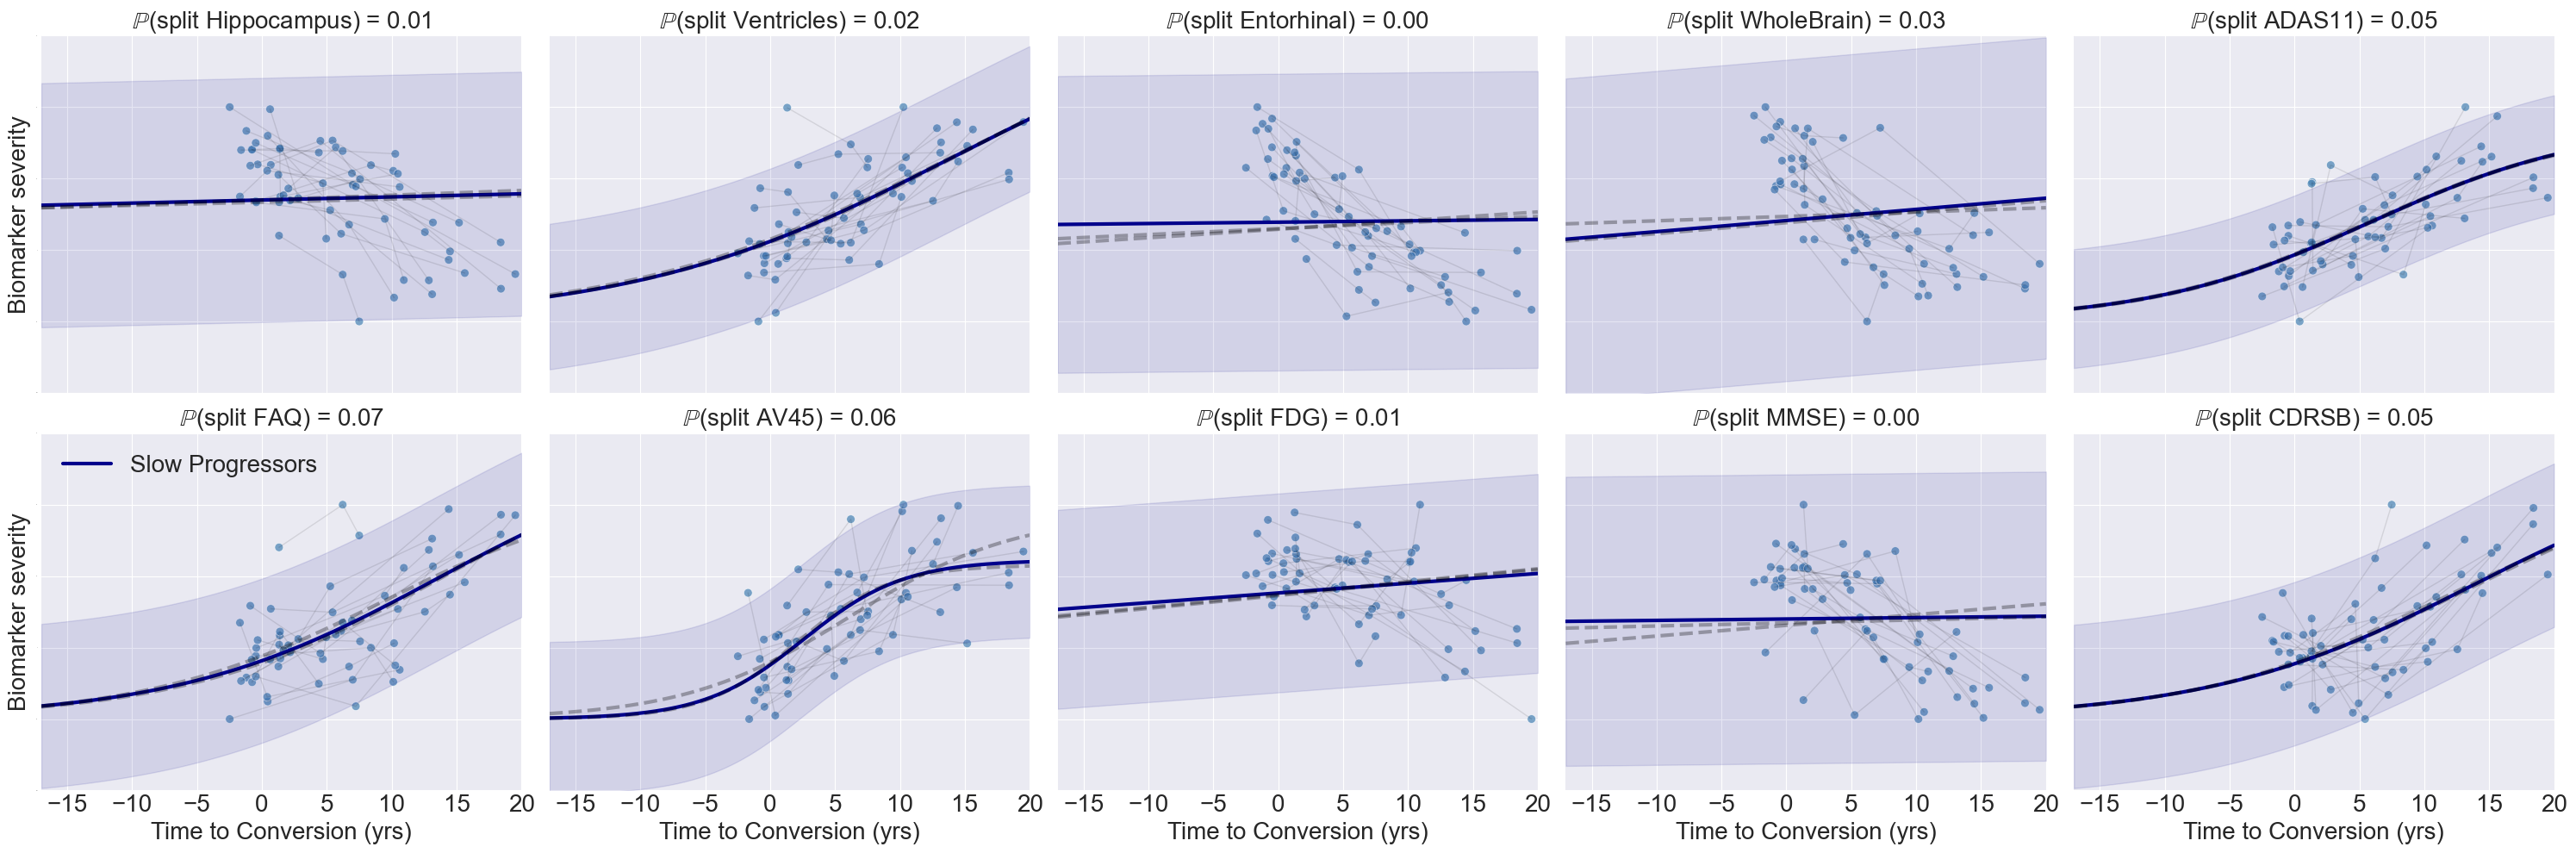

In [59]:
plot_solution(dpmost, save=False, n_for_col=5, figsize=[30,10],x_lim=[-17,20], y_lim=[-1,4], label=['Slow Progressors', 'Fast Progressors'],
              n_label=5, dpi=dpi, plot_x_axis=True, plot_y_axis=False, fontsize=20, print_noise=False, show_alternatives=True)